In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

## Lasso Regression

__LASSO:__ Least Absolute Shrinkage and Selection Operator
- Ridge regression shrinks parameter estimates, but estimates never reach 0
- Lasso optimization tries to force small parameter estimates to equal 0 (effectively dropping them from the model)
- Can prevent overfitting
- Works as an embedded feature selection method
- Good for handling thousands (or hundreds of thousands) of predictors and need to optimize processor time
- Also good for arriving at simpler, easier to interpret solutions
$$\sum_{i=1}^n(y_i-(\alpha+\beta x_i))^2+\lambda\sum_{j=1}^p|\beta_j|$$

Lasso penalizes the sum of the absolute values the coefficients as opposed to penalizing the sum of squared coefficients (ridge). Penalty doesn't increase as swiftly with coefficient size.

## Fitting Lasso: Coordinate Descent Algorithm

Pick starting value for $\beta$, often $\beta=0$

For each feature $j$ in $\beta$:
- Predict the outcome using all features except for $j$
- Look at how residuals from model using all $\beta$s (except $j$) correlate with feature $j$, called $\rho_j$
- If correlation falls within an area enclosing 0 defined by $\lambda$, set $\beta_j=0$ (soft thresholding)
- if $\rho_j<\lambda/2$, then $\beta_j=\rho_j+\lambda/2$
- if $\rho_j>\lambda/2$, then $\beta_j=\rho_j-\lambda/2$

This iterates through all features 1 through $j$ on each cycle, then begins again. The algorithm can also be set to choose to exclude a feature at random each iteration). Each time a feature is checked it shrinks a little from the previous time it was checked (unless it is already set to 0, which it will remain). The algorithm runs until the maximum difference between parameter estimates in the previous and current cycle is less than a pre-determined threshold $tol$
- SKlearn default $tol=0.0001$

In [2]:
#load data, drop index column and missing data columns
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:,1:].dropna()
print(df.head())

#recode strings to numeric
df['default'] = np.where(df['default'] == 'Yes', 1, 0)
df['student'] = np.where(df['student'] == 'Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

#define train and test sizes
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1,1)
X_train = df_train.loc[:,~(df_train.columns).isin(['income'])]

#make some new features to capture potential quadratic and cubic relationships
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:,~(df_train.columns).isin(['income'])]

#test simple model with smaller coefficients
Y_test = df_test['income'].values.reshape(-1,1)
X_test = df_test.loc[:,~(df_test.columns).isin(['income'])]

#test more complex model with larger coefficients
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]

  default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879


In [3]:
#small number of parameters
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R-squared for model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

#large number of parameters
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
print('R-squared for model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R-squared for model with few features:
0.450062579301185

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]
R-squared for model with many features:
0.44363376712897085

Parameter estimates for the model with many features:
[ 0.00000000e+00 -3.89351238e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.77688887e-04
 -7.09158792e-07  3.48711577e+00]


In [4]:
#check with test set
print(lass.score(X_test,Y_test))
print(lassBig.score(X_test2,Y_test))

0.44553225151184195
0.4380466345914476


## Regularization parameter: Lasso

The $\lambda$ for lasso can var between 0 and infinity, if $\lambda$ is too large, all parameters will be set to zero. 

Create a plot below of how $R^2$ varies across different values of $\lambda$ for ridge and lasso regression. Use logic and code similar to the ridge regression demonstration above, and base your plot on the X_train2 feature set.

Do lasso and ridge yield the same $R^2$ for a given lambda value?

In [5]:
lassBig = linear_model.Lasso(alpha=.0075)
lassBig.fit(X_train2, Y_train)
print('R-squared for model with many features:')
print(lassBig.score(X_train2, Y_train))

R-squared for model with many features:
0.573825601682644


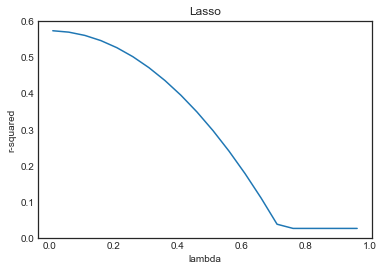

In [6]:
rvals_lasso = []

for lambd in np.arange(.01,1,.05):
    lassBig = linear_model.Lasso(alpha=lambd)
    lassBig.fit(X_train2,Y_train)
    rvals_lasso.append([lambd, lassBig.score(X_train2, Y_train)])

lass_df = pd.DataFrame(
    rvals_lasso,
    columns=['lambda']+['r-squared'])
lass_df.sort_values(by='lambda', inplace=True, ascending=True)

plt.plot(lass_df['lambda'], lass_df['r-squared'])
plt.xlabel('lambda')
plt.ylabel('r-squared')
plt.title('Lasso')
plt.show()

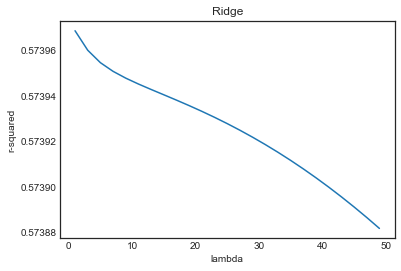

In [7]:
rvals_ridge = []

for lambd in np.arange(1,50,2):
    ridgeBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeBig.fit(X_train2,Y_train)
    rvals_ridge.append([lambd, ridgeBig.score(X_train2, Y_train)])

ridge_df = pd.DataFrame(
    rvals_ridge,
    columns=['lambda']+['r-squared'])
ridge_df.sort_values(by='lambda', inplace=True, ascending=True)

plt.plot(ridge_df['lambda'], ridge_df['r-squared'])
plt.xlabel('lambda')
plt.ylabel('r-squared')
plt.title('Ridge')
plt.show()